In [ ]:
from joblib import dump, load
from pathlib import Path

from fastai.tabular.core import cont_cat_split, TabularPandas, Categorify
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# For handling grid search parallelization
import os
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'

## Load data

In [ ]:
path = Path('.')
data_path = path / 'data'
searches_path = path / 'searches'
searches_path.mkdir(exist_ok=True)
models_path = path / 'models'

In [ ]:
train_frac = 0.85
valid_frac = 0.05

In [ ]:
def make_splits(df, random_seed=42, train_frac=0.85, valid_frac=0.05):
    train_indices = list(df.sample(frac=train_frac, random_state=random_seed).index)
    valid_indices = list(df[~df.index.isin(train_indices)].sample(frac=valid_frac/(1-train_frac), random_state=random_seed).index)
    test_indices = list(df[~df.index.isin(train_indices+valid_indices)].index)
    
    # Check if the train, validation and test sets are mutually exclusive
    assert len(set(train_indices).intersection(valid_indices)) == 0
    assert len(set(train_indices).intersection(test_indices)) == 0
    assert len(set(valid_indices).intersection(test_indices)) == 0
    
    return train_indices, valid_indices, test_indices

In [ ]:
def create_dset():
    df = pd.read_pickle(data_path/'df_mc.pkl')
    # Reset index and avoid new column creation
    df.reset_index(inplace=True, drop=True)
    # Split the rescaled weights into a separate df
    weights = df['rescaled_weight']
    df.drop('rescaled_weight', axis=1, inplace=True)
    
    train_indices, valid_indices, test_indices = make_splits(df, train_frac=train_frac, valid_frac=valid_frac)
    cont, cat = cont_cat_split(df, dep_var='label')
    procs = [Categorify]
    to = TabularPandas(df, procs=procs, cont_names=cont, cat_names=cat, y_names='label', splits=(train_indices, valid_indices))
    train_xs, train_y = to.train.xs, to.train.y
    valid_xs, valid_y = to.valid.xs, to.valid.y
    
    print(f"Training set: {len(train_y)} samples")
    print(f"Validation set: {len(valid_y)} samples")
    
    test_to = TabularPandas(df, procs=procs, cont_names=cont, cat_names=cat, y_names='label', splits=(train_indices, test_indices))
    test_xs, test_y = test_to.valid.xs, test_to.valid.y
    assert len(test_y) == len(test_indices)
    print(f"Test set: {len(test_y)} samples")
    print(f"Total: {len(train_y)+len(valid_y)+len(test_y)} samples")
    
    return train_xs, train_y, valid_xs, valid_y, test_xs, test_y, weights

In [ ]:
# If the data is stored, load it
if (data_path/'train_xs.pkl').exists():
    print('Loading data')
    train_xs = pd.read_pickle(data_path/'train_xs.pkl')
    train_y = pd.read_pickle(data_path/'train_y.pkl')
    valid_xs = pd.read_pickle(data_path/'valid_xs.pkl')
    valid_y = pd.read_pickle(data_path/'valid_y.pkl')
    test_xs = pd.read_pickle(data_path/'test_xs.pkl')
    test_y = pd.read_pickle(data_path/'test_y.pkl')
    weights = pd.read_pickle(data_path/'weights.pkl')
else:
    print('Creating dataset')
    train_xs, train_y, valid_xs, valid_y, test_xs, test_y, weights = create_dset()
    print('Saving dataset')
    train_xs.to_pickle(data_path/'train_xs.pkl')
    train_y.to_pickle(data_path/'train_y.pkl')
    valid_xs.to_pickle(data_path/'valid_xs.pkl')
    valid_y.to_pickle(data_path/'valid_y.pkl')
    test_xs.to_pickle(data_path/'test_xs.pkl')
    test_y.to_pickle(data_path/'test_y.pkl')
    weights.to_pickle(data_path/'weights.pkl')
    print('Done')

Loading data


In [ ]:
# Train indices, validation indices and test indices
train_indices = train_xs.index
valid_indices = valid_xs.index
test_indices = test_xs.index

In [ ]:
pd.DataFrame(weights[train_indices])

,rescaled_weight
336596,0.000622
1046443,0.000402
994441,0.000627
131389,0.000868
45434,0.000367
...,...
1006448,0.000314
928535,0.000115
489160,0.009223
367127,0.001042


In [ ]:
train_xs

,lep1_ch,lep1_ID,lep2_ch,lep2_ID,lep3_ch,lep3_ID,mLL,zdiff,ptLL,etmiss,...,lep1_E,lep1_phi,lep2_pt,lep2_eta,lep2_E,lep2_phi,lep3_pt,lep3_eta,lep3_E,lep3_phi
336596,1,2,2,2,1,2,96.502403,5.3148,374.562012,139.772003,...,511.713989,-2.265320,123.869003,1.036290,196.550003,-1.791720,96.322403,2.410790,540.968994,0.938905
1046443,1,2,1,2,2,2,89.442703,1.7449,43.378502,32.666199,...,73.728203,-2.023860,48.103100,-0.723214,61.241100,2.188150,22.529400,1.126400,38.398399,-2.075760
994441,1,2,2,2,1,2,93.114700,1.9271,112.532997,123.005997,...,102.577003,2.889160,43.555801,0.118866,43.863899,-1.878940,42.452999,-2.059490,169.164001,-0.918927
131389,2,1,2,1,1,1,87.930702,3.2569,155.957993,52.175999,...,168.770996,1.704090,48.442001,0.826741,65.961800,0.835879,23.199600,0.727952,29.622801,1.862130
45434,2,2,2,1,1,2,69.468399,21.7192,166.714005,68.529602,...,251.166000,0.220220,107.225998,-0.719294,136.181000,2.787720,40.399200,-1.970560,147.742004,-0.400392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006448,1,2,2,1,2,2,94.582497,3.3949,97.462898,5.116620,...,326.351990,0.110376,41.917301,-1.214690,76.835701,2.600100,26.451799,-2.102820,109.925003,2.212820
928535,2,2,1,2,2,2,90.003304,1.1843,28.004601,33.743801,...,50.987099,-2.123430,41.115398,-0.363855,43.867298,1.686230,26.725599,1.725110,77.387901,1.914650
489160,2,1,1,1,2,1,94.835403,3.6478,54.816700,29.547701,...,159.503006,2.888040,43.648701,1.142870,75.396004,0.759834,43.244801,-0.614007,51.655899,-0.309172
367127,1,2,2,2,1,1,92.213501,1.0259,133.578995,16.742399,...,599.797974,-1.662810,31.187300,-1.365510,65.071602,-2.902700,24.810900,-2.306370,125.761002,1.350200


## Train models

In [ ]:
import re

import graphviz
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

### Decision Tree

In [ ]:
m1 = DecisionTreeClassifier(max_depth=2)
m1.fit(train_xs, train_y)

DecisionTreeClassifier(max_depth=2)

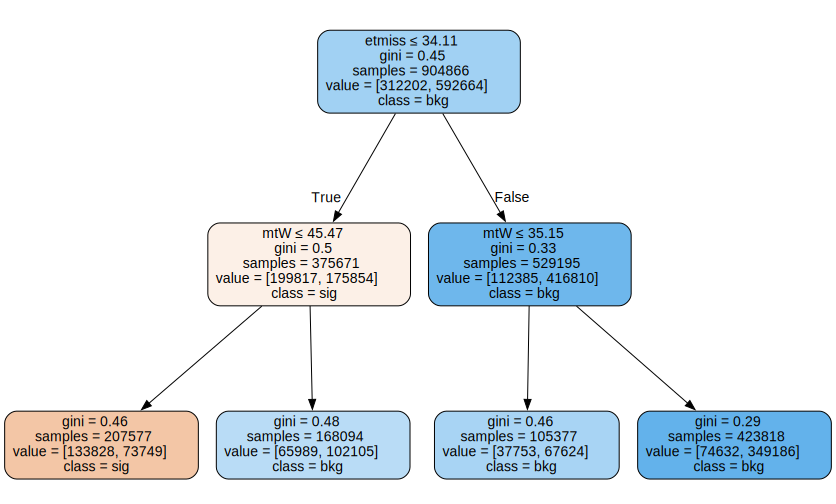

In [ ]:
fig = draw_tree(m1, train_xs, size=15, leaves_parallel=False, precision=2, class_names=['sig', 'bkg'])
#fig.render('first_tree', format='png', cleanup=True)
fig

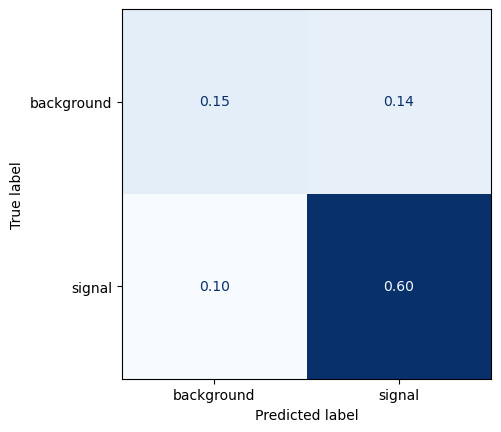

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_estimator(m1, valid_xs, valid_y, 
                                           sample_weight=weights[valid_indices],
                                           cmap='Blues', display_labels=['background', 'signal'], 
                                           colorbar=False, values_format='.2f', normalize='all')

In [ ]:
print(f'#signals / #backgrounds: {cm.confusion_matrix[1, 1] / cm.confusion_matrix[0, 1]:.2f}')
print(f'Precision: {cm.confusion_matrix[1, 1] / (cm.confusion_matrix[1, 1] + cm.confusion_matrix[0, 1]):.2f}')
print(f'True positives: {cm.confusion_matrix[1, 1]}')

#signals / #backgrounds: 4.25
Precision: 0.81
True positives: 1223.3661391107673


In [ ]:
m1 = DecisionTreeClassifier(max_depth=2)
m1.fit(train_xs, train_y, sample_weight=weights[train_indices])

DecisionTreeClassifier(max_depth=2)

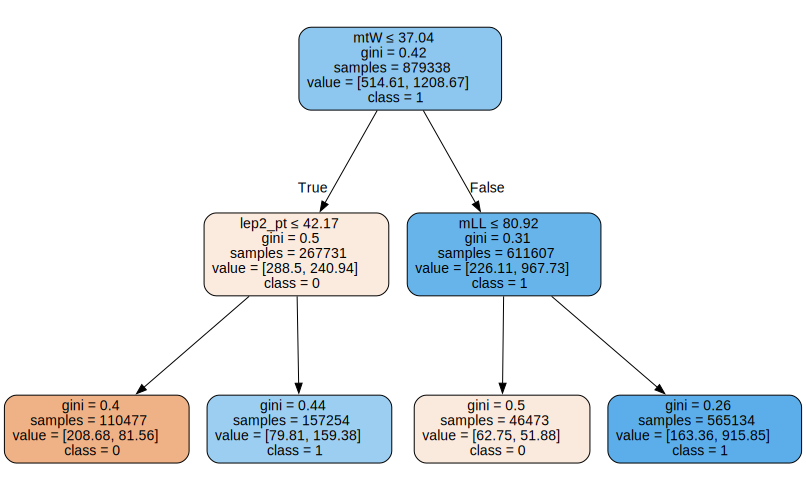

In [ ]:
draw_tree(m1, train_xs, size=15, leaves_parallel=False, precision=2, class_names=['0', '1'])

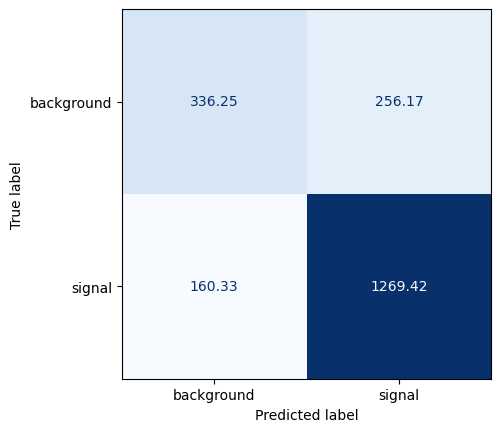

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_estimator(m1, valid_xs, valid_y, 
                                           sample_weight=weights[valid_indices]/valid_frac,
                                           cmap='Blues', display_labels=['background', 'signal'], 
                                           colorbar=False, values_format='.2f')

In [ ]:
print(f'#signals / #backgrounds: {cm.confusion_matrix[1, 1] / cm.confusion_matrix[0, 1]:.2f}')

#signals / #backgrounds: 4.96


In [ ]:
prec = metrics.precision_score(valid_y, m1.predict(valid_xs), sample_weight=weights[valid_indices])
ratio = prec / (1-prec)

prec, ratio

(0.8320850527882755, 4.9553959704319634)

In [ ]:
m2 = DecisionTreeClassifier(max_depth=2, class_weight='balanced')
m2.fit(train_xs, train_y)

DecisionTreeClassifier(class_weight='balanced', max_depth=2)

In [ ]:
cm = metrics.confusion_matrix(valid_y, m2.predict(valid_xs), sample_weight=weights[valid_indices]/valid_frac)
print(cm)
print(f'#signals / #backgrounds: {cm[1, 1] / cm[0, 1]:.2f}')

[[412.12194748 180.29375685]
 [551.6201423  878.12935317]]
#signals / #backgrounds: 4.87


#### Number of leaf nodes

In [ ]:
# Create a weighted metric decorator
def weighted_metric(metric):
    def weighted_metric_impl(y_true, y_pred, sample_weight):
        return metric(y_true, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.flatten())
    return weighted_metric_impl

# Create a weighted precision metric
weighted_precision_score = weighted_metric(metrics.precision_score)

In [ ]:
def weighted_true_positives(y_true, y_pred, sample_weight):
    cm = metrics.confusion_matrix(y_true, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.flatten())
    return cm[1, 1]/cm.sum().sum()

In [ ]:
xs = pd.concat([train_xs, valid_xs])
y = pd.concat([train_y, valid_y])
sample_weights = weights[train_indices+valid_indices]

score_params = {'sample_weight': sample_weights}
scoring = {'precision': metrics.make_scorer(weighted_precision_score, **score_params),
           'true_positives': metrics.make_scorer(weighted_true_positives, **score_params)}

In [ ]:
param_grid = {'max_leaf_nodes': [2**i for i in range(1, 9)]}

dt_cls = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_cls, param_grid, cv=5, scoring=scoring,
                           return_train_score=True, verbose=4, 
                           refit=False, n_jobs=5)

In [ ]:
grid_search.fit(xs, y, sample_weight=sample_weights)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 3/5] END max_leaf_nodes=2; precision: (train=0.827, test=0.823) true_positives: (train=0.525, test=0.524) total time=  14.0s
[CV 4/5] END max_leaf_nodes=2; precision: (train=0.812, test=0.814) true_positives: (train=0.560, test=0.556) total time=  14.5s
[CV 5/5] END max_leaf_nodes=2; precision: (train=0.825, test=0.831) true_positives: (train=0.522, test=0.533) total time=  14.2s
[CV 1/5] END max_leaf_nodes=2; precision: (train=0.818, test=0.800) true_positives: (train=0.558, test=0.541) total time=  14.9s
[CV 2/5] END max_leaf_nodes=2; precision: (train=0.812, test=0.811) true_positives: (train=0.559, test=0.569) total time=  15.0s
[CV 1/5] END max_leaf_nodes=4; precision: (train=0.820, test=0.806) true_positives: (train=0.625, test=0.608) total time=  14.4s
[CV 4/5] END max_leaf_nodes=4; precision: (train=0.815, test=0.823) true_positives: (train=0.624, test=0.620) total time=  14.6s
[CV 5/5] END max_leaf_nodes=4; precis

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=5,
             param_grid={'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128, 256]},
             refit=False, return_train_score=True,
             scoring={'precision': make_scorer(weighted_metric_impl, sample_weight=336596     0.000622
1046443    0.000402
994441     0.000627
131389     0.000868
45434      0.000367
             ...   
957916    -0.001084
557435     0.009622
834372     0.000635
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64),
                      'true_positives': make_scorer(weighted_true_positives, sample_weight=336596     0.000622
1046443    0.000402
994441     0.000627
131389     0.000868
45434      0.000367
             ...   
957916    -0.001084
557435     0.009622
834372     0.000635
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64)},
             verbose=4)

In [ ]:
fname = 'dt_grid_search1.pkl'
if not (searches_path/fname).exists():
    grid_search_results = pd.DataFrame(grid_search.cv_results_)
    grid_search_results.to_pickle(searches_path/fname)
else:
    grid_search_results = pd.read_pickle(searches_path/fname)
    print('Loaded grid search results')

Loaded grid search results


<matplotlib.legend.Legend>

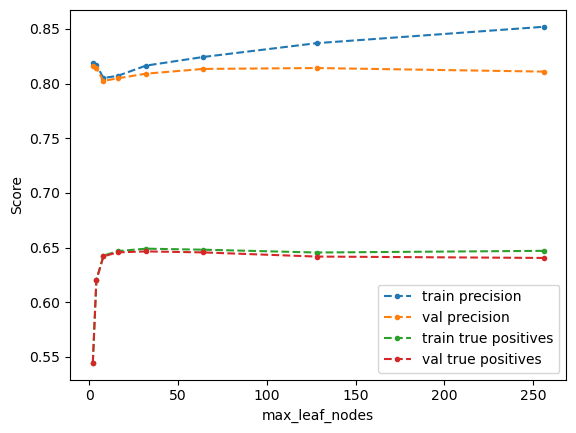

In [ ]:
plt.plot(param_grid['max_leaf_nodes'], grid_search.cv_results_['mean_train_precision'], '--.', label='train precision')
plt.plot(param_grid['max_leaf_nodes'], grid_search.cv_results_['mean_test_precision'], '--.', label='val precision')
plt.plot(param_grid['max_leaf_nodes'], grid_search.cv_results_['mean_train_true_positives'], '--.', label='train true positives')
plt.plot(param_grid['max_leaf_nodes'], grid_search.cv_results_['mean_test_true_positives'], '--.', label='val true positives')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Score')
plt.legend()

#### Class weight

In [ ]:
param_grid = {'max_leaf_nodes': [2**i for i in range(1, 8)], 
              'class_weight': [None, 'balanced']}

dt_cls = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_cls, param_grid, cv=5, scoring=scoring,
                           return_train_score=True, verbose=4, 
                           refit=False, n_jobs=5)

In [ ]:
grid_search.fit(xs, y, sample_weight=sample_weights)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[CV 5/5] END class_weight=None, max_leaf_nodes=2; precision: (train=0.825, test=0.831) true_positives: (train=0.522, test=0.533) total time=  10.1s
[CV 3/5] END class_weight=None, max_leaf_nodes=2; precision: (train=0.827, test=0.823) true_positives: (train=0.525, test=0.524) total time=  10.4s
[CV 1/5] END class_weight=None, max_leaf_nodes=2; precision: (train=0.818, test=0.800) true_positives: (train=0.558, test=0.541) total time=  10.3s
[CV 2/5] END class_weight=None, max_leaf_nodes=2; precision: (train=0.812, test=0.811) true_positives: (train=0.559, test=0.569) total time=  10.8s
[CV 4/5] END class_weight=None, max_leaf_nodes=2; precision: (train=0.812, test=0.814) true_positives: (train=0.560, test=0.556) total time=  10.9s
[CV 1/5] END class_weight=None, max_leaf_nodes=4; precision: (train=0.820, test=0.806) true_positives: (train=0.625, test=0.608) total time=  15.8s
[CV 2/5] END class_weight=None, max_leaf_nodes=4; precision: (train=0.819, test=0.810) true_positives: (train=0.

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=5,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128]},
             refit=False, return_train_score=True,
             scoring={'precision': make_scorer(weighted_metric_impl, sample_weight=336596     0.000622
1046443    0.000402
994441     0.000627
131389     0.000868
45434      0.000367
             ...   
957916    -0.001084
557435     0.0096...
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64),
                      'true_positives': make_scorer(weighted_true_positives, sample_weight=336596     0.000622
1046443    0.000402
994441     0.000627
131389     0.000868
45434      0.000367
             ...   
957916    -0.001084
557435     0.009622
834372     0.000635
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64)},
             verbose=4)

In [ ]:
fname = 'dt_grid_search2.pkl'
if not (searches_path/fname).exists():
    grid_search_results = pd.DataFrame(grid_search.cv_results_)
    grid_search_results.to_pickle(searches_path/fname)
else:
    grid_search_results = pd.read_pickle(searches_path/fname)
    print('Loaded grid search results')

Loaded grid search results


[Text(0, 0, 'None'), Text(1, 0, 'balanced')]

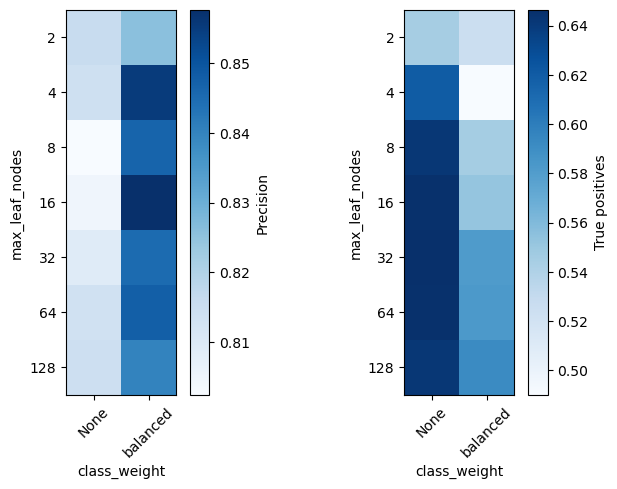

In [ ]:
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
scores = grid_search.cv_results_['mean_test_precision'].reshape(len(param_grid['max_leaf_nodes']), len(param_grid['class_weight']), order='F')
plt.imshow(scores, interpolation='nearest', cmap='Blues')
plt.colorbar(label='Precision')
plt.xlabel('class_weight')
plt.ylabel('max_leaf_nodes')
plt.yticks(range(len(param_grid['max_leaf_nodes'])), param_grid['max_leaf_nodes'])
plt.xticks(range(len(param_grid['class_weight'])), param_grid['class_weight'], rotation=45)
plt.gca().set_xticklabels(['None', 'balanced'])

plt.subplot(1, 2, 2)
scores = grid_search.cv_results_['mean_test_true_positives'].reshape(len(param_grid['max_leaf_nodes']), len(param_grid['class_weight']), order='F')
plt.imshow(scores, interpolation='nearest', cmap='Blues')
plt.colorbar(label='True positives')
plt.xlabel('class_weight')
plt.ylabel('max_leaf_nodes')
plt.yticks(range(len(param_grid['max_leaf_nodes'])), param_grid['max_leaf_nodes'])
plt.xticks(range(len(param_grid['class_weight'])), param_grid['class_weight'], rotation=45)
plt.gca().set_xticklabels(['None', 'balanced'])

<matplotlib.legend.Legend>

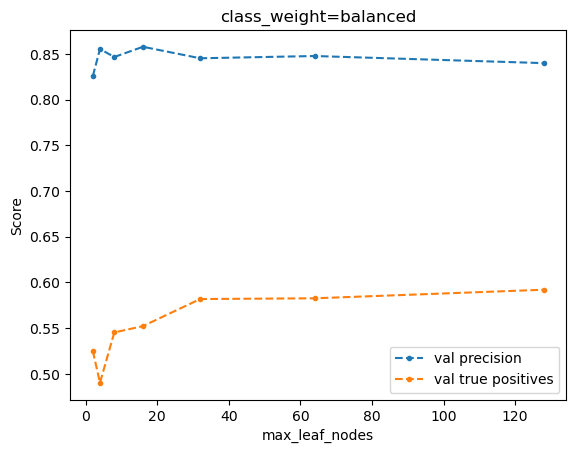

In [ ]:
start_index = len(param_grid['max_leaf_nodes'])

plt.plot(param_grid['max_leaf_nodes'], grid_search.cv_results_['mean_test_precision'][start_index:], '--.', label='val precision')
plt.plot(param_grid['max_leaf_nodes'], grid_search.cv_results_['mean_test_true_positives'][start_index:], '--.', label='val true positives')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Score')
plt.title('class_weight=balanced')
plt.legend()

In [ ]:
param_grid = {'max_leaf_nodes': [2**i for i in range(1, 7)], 
              'class_weight': [{0: x, 1:1} for x in np.linspace(1.5, 6, 10)]}

dt_cls = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_cls, param_grid, cv=5, scoring=scoring,
                           return_train_score=True, verbose=4, 
                           refit=False, n_jobs=5)

In [ ]:
grid_search.fit(xs, y, sample_weight=sample_weights)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END class_weight={0: 1.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.822, test=0.805) true_positives: (train=0.545, test=0.529) total time=   9.6s
[CV 3/5] END class_weight={0: 1.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.827, test=0.823) true_positives: (train=0.525, test=0.524) total time=  10.1s
[CV 2/5] END class_weight={0: 1.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.826, test=0.829) true_positives: (train=0.523, test=0.531) total time=  10.1s
[CV 5/5] END class_weight={0: 1.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.700, test=0.710) true_positives: (train=0.700, test=0.709) total time=  11.0s
[CV 4/5] END class_weight={0: 1.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.825, test=0.829) true_positives: (train=0.526, test=0.525) total time=  11.6s
[CV 1/5] END class_weight={0: 1.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.821, test=0.808) true_positives: (train=0.621, test=0.604) total tim

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 2.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=   9.7s
[CV 5/5] END class_weight={0: 2.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.825, test=0.831) true_positives: (train=0.522, test=0.533) total time=   9.9s
[CV 5/5] END class_weight={0: 2.0, 1: 1}, max_leaf_nodes=64; precision: (train=0.856, test=0.857) true_positives: (train=0.582, test=0.589) total time=  43.0s
[CV 2/5] END class_weight={0: 2.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.880, test=0.876) true_positives: (train=0.444, test=0.450) total time=  15.2s
[CV 1/5] END class_weight={0: 2.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.876, test=0.860) true_positives: (train=0.469, test=0.453) total time=  18.4s
[CV 3/5] END class_weight={0: 2.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.888, test=0.878) true_positives: (train=0.422, test=0.422) total time=  15.6s
[CV 4/5] END class_weight={0: 2.5, 1: 1}, max_leaf_

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END class_weight={0: 3.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  14.6s
[CV 2/5] END class_weight={0: 3.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.826, test=0.829) true_positives: (train=0.523, test=0.531) total time=  15.1s
[CV 3/5] END class_weight={0: 3.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.836, test=0.827) true_positives: (train=0.497, test=0.496) total time=  14.2s
[CV 4/5] END class_weight={0: 3.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.831, test=0.835) true_positives: (train=0.506, test=0.504) total time=  14.6s
[CV 5/5] END class_weight={0: 3.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.831, test=0.836) true_positives: (train=0.503, test=0.515) total time=  14.2s
[CV 5/5] END class_weight={0: 3.0, 1: 1}, max_leaf_nodes=64; precision: (train=0.894, test=0.888) true_positives: (train=0.486, test=0.493) total time=  59.3s
[CV 2/5] END class_weight={0: 3.5, 1: 1}, max_leaf_

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 4.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  11.9s
[CV 1/5] END class_weight={0: 4.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.835, test=0.820) true_positives: (train=0.509, test=0.494) total time=  12.8s
[CV 3/5] END class_weight={0: 4.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.836, test=0.827) true_positives: (train=0.497, test=0.496) total time=  12.7s
[CV 4/5] END class_weight={0: 4.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.836, test=0.839) true_positives: (train=0.488, test=0.486) total time=  11.9s
[CV 5/5] END class_weight={0: 4.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.831, test=0.836) true_positives: (train=0.503, test=0.515) total time=  12.2s
[CV 1/5] END class_weight={0: 4.0, 1: 1}, max_leaf_nodes=4; precision: (train=0.885, test=0.867) true_positives: (train=0.442, test=0.428) total time=  16.6s
[CV 3/5] END class_weight={0: 4.0, 1: 1}, max_leaf_n

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END class_weight={0: 4.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.840, test=0.825) true_positives: (train=0.491, test=0.475) total time=  17.2s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 4.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  14.7s
[CV 3/5] END class_weight={0: 4.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.836, test=0.827) true_positives: (train=0.497, test=0.496) total time=  15.0s
[CV 4/5] END class_weight={0: 4.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.836, test=0.839) true_positives: (train=0.488, test=0.486) total time=  15.4s
[CV 5/5] END class_weight={0: 4.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.835, test=0.839) true_positives: (train=0.490, test=0.501) total time=  14.1s
[CV 1/5] END class_weight={0: 4.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.890, test=0.871) true_positives: (train=0.427, test=0.412) total time=  21.3s
[CV 2/5] END class_weight={0: 4.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.880, test=0.876) true_positives: (train=0.444, test=0.450) total time=  25.9s
[CV 3/5] END class_weight={0: 4.5, 1: 1}, max_leaf_n

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 5.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  15.4s
[CV 4/5] END class_weight={0: 5.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.836, test=0.839) true_positives: (train=0.488, test=0.486) total time=  15.0s
[CV 3/5] END class_weight={0: 5.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.836, test=0.827) true_positives: (train=0.497, test=0.496) total time=  15.8s
[CV 5/5] END class_weight={0: 5.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.835, test=0.839) true_positives: (train=0.490, test=0.501) total time=  16.1s
[CV 1/5] END class_weight={0: 5.0, 1: 1}, max_leaf_nodes=4; precision: (train=0.891, test=0.872) true_positives: (train=0.423, test=0.409) total time=  23.9s
[CV 2/5] END class_weight={0: 5.0, 1: 1}, max_leaf_nodes=4; precision: (train=0.880, test=0.876) true_positives: (train=0.444, test=0.450) total time=  24.2s
[CV 3/5] END class_weight={0: 5.0, 1: 1}, max_leaf_n

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  15.1s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  15.4s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  16.3s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  16.2s
[CV 5/5] END class_weight={0: 5.0, 1: 1}, max_leaf_nodes=64; precision: (train=0.912, test=0.896) true_positives: (train=0.422, test=0.426) total time= 1.1min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  14.7s
[CV 1/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.891, test=0.872) true_positives: (train=0.423, test=0.409) total time=  22.4s
[CV 3/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.891, test=0.880) true_positives: (train=0.413, test=0.412) total time=  23.6s
[CV 2/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.880, test=0.876) true_positives: (train=0.444, test=0.450) total time=  27.7s
[CV 4/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.890, test=0.889) true_positives: (train=0.413, test=0.414) total time=  23.6s
[CV 5/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=4; precision: (train=0.886, test=0.899) true_positives: (train=0.416, test=0.425) total time=  25.3s
[CV 1/5] END class_weight={0: 5.5, 1: 1}, max_leaf_n

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  15.1s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  14.9s
[CV 4/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=64; precision: (train=0.914, test=0.901) true_positives: (train=0.414, test=0.415) total time= 1.1min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  15.7s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  15.2s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=2; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  13.4s
[CV 5/5] END class_weight={0: 5.5, 1: 1}, max_leaf_nodes=64; precision: (train=0.924, test=0.904) true_positives: (train=0.366, test=0.366) total time= 1.1min
[CV 1/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4; precision: (train=0.891, test=0.872) true_positives: (train=0.423, test=0.409) total time=  20.6s
[CV 2/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4; precision: (train=0.887, test=0.880) true_positives: (train=0.414, test=0.420) total time=  18.4s
[CV 3/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4; precision: (train=0.891, test=0.880) true_positives: (train=0.413, test=0.413) total time=  21.6s
[CV 4/5] END class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4; precision: (train=0.890, test=0.889) true_positives: (train=0.413, test=0.413) total time=  23.7s
[CV 5/5] END class_weight={0: 6.0, 1: 1}, max_leaf_

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=5,
             param_grid={'class_weight': [{0: 1.5, 1: 1}, {0: 2.0, 1: 1},
                                          {0: 2.5, 1: 1}, {0: 3.0, 1: 1},
                                          {0: 3.5, 1: 1}, {0: 4.0, 1: 1},
                                          {0: 4.5, 1: 1}, {0: 5.0, 1: 1},
                                          {0: 5.5, 1: 1}, {0: 6.0, 1: 1}],
                         'max_leaf_nodes': [2, 4, 8, 16, 32, 64]},
             refit=False, return_train_score=True,
             scoring={'precision': make_scorer(weighted_metric_impl, sample_weight=...
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64),
                      'true_positives': make_scorer(weighted_true_positives, sample_weight=336596     0.000622
1046443    0.000402
994441     0.000627
131389     0.000868
45434      0.000367
             ...   
957916    -0.001084
557435     0.009622
834372     0.000635
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64)},
             verbose=4)

In [ ]:
fname = 'dt_grid_search3.pkl'
if not (searches_path/fname).exists():
    grid_search_results = pd.DataFrame(grid_search.cv_results_)
    grid_search_results.to_pickle(searches_path/fname)
else:
    print('loaded results')
    grid_search_results = pd.read_pickle(searches_path/fname)

loaded results


In [ ]:
def get_weight_ratios(class_weight_dicts):
    for class_weight_dict in class_weight_dicts:
        yield class_weight_dict[0]

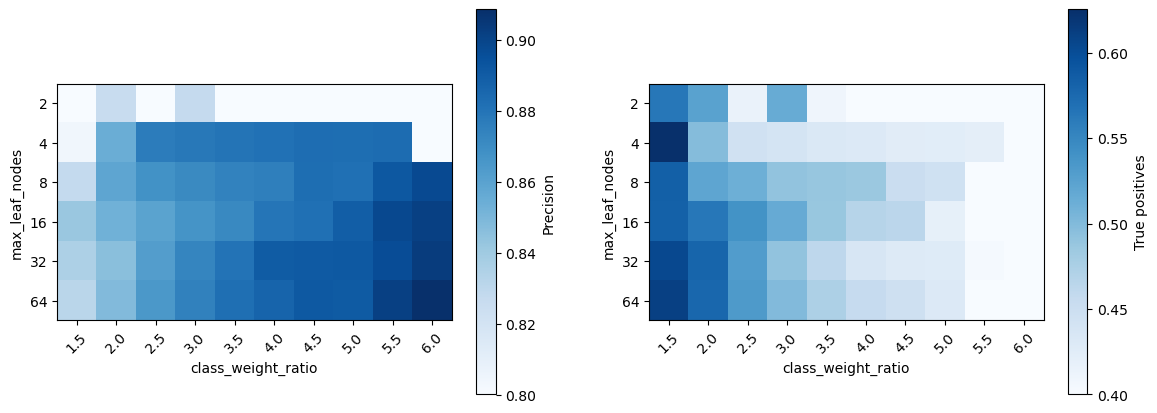

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
scores = grid_search.cv_results_['mean_test_precision'].reshape(len(param_grid['max_leaf_nodes']), len(param_grid['class_weight']), order='F')
plt.imshow(scores, interpolation='nearest', cmap='Blues', vmin=0.8)
plt.colorbar(label='Precision')
plt.xlabel('class_weight_ratio')
plt.ylabel('max_leaf_nodes')
plt.yticks(range(len(param_grid['max_leaf_nodes'])), param_grid['max_leaf_nodes'])
plt.xticks(range(len(param_grid['class_weight'])), get_weight_ratios(param_grid['class_weight']), rotation=45)

plt.subplot(1, 2, 2)
scores = grid_search.cv_results_['mean_test_true_positives'].reshape(len(param_grid['max_leaf_nodes']), len(param_grid['class_weight']), order='F')
plt.imshow(scores, interpolation='nearest', cmap='Blues', vmin=0.35)
plt.colorbar(label='True positives')
plt.xlabel('class_weight_ratio')
plt.ylabel('max_leaf_nodes')
plt.yticks(range(len(param_grid['max_leaf_nodes'])), param_grid['max_leaf_nodes'])
plt.xticks(range(len(param_grid['class_weight'])), get_weight_ratios(param_grid['class_weight']), rotation=45);

In [ ]:
# Split params into separate columns, class_weights and max_leaf_nodes
params = grid_search_results.params.apply(pd.Series)
grid_search_results = pd.concat([grid_search_results, params], axis=1).drop('params', axis=1)
# Drop split0, split1, ... columns
grid_search_results = grid_search_results.loc[:, ~grid_search_results.columns.str.startswith('split')]
# Drop std_ columns
grid_search_results = grid_search_results.loc[:, ~grid_search_results.columns.str.startswith('std_')]


In [ ]:
grid_search_results.query('mean_test_precision > 0.8 and mean_test_true_positives > 0.35').sort_values('mean_test_precision', ascending=False).head()

,mean_fit_time,mean_score_time,param_class_weight,param_max_leaf_nodes,mean_test_precision,rank_test_precision,mean_train_precision,mean_test_true_positives,rank_test_true_positives,mean_train_true_positives,class_weight,max_leaf_nodes
59,44.864353,0.272600,"{0: 6.0, 1: 1}",64,0.908723,1,0.927534,0.350962,56,0.353469,"{0: 6.0, 1: 1}",64
58,41.830003,0.307793,"{0: 6.0, 1: 1}",32,0.903312,2,0.915452,0.374845,53,0.375555,"{0: 6.0, 1: 1}",32
53,63.242447,0.413933,"{0: 5.5, 1: 1}",64,0.901581,4,0.919877,0.388432,52,0.389660,"{0: 5.5, 1: 1}",64
51,44.076512,0.450463,"{0: 5.5, 1: 1}",16,0.898201,5,0.907744,0.353718,55,0.354550,"{0: 5.5, 1: 1}",16
56,30.729033,0.374918,"{0: 6.0, 1: 1}",8,0.897798,6,0.901145,0.364203,54,0.363464,"{0: 6.0, 1: 1}",8


### Best DT

In [ ]:
xs = pd.concat([train_xs, valid_xs])
y = pd.concat([train_y, valid_y])
sample_weights = pd.concat([weights[train_indices], weights[valid_indices]])

In [ ]:
fname = 'best_dt.joblib'
if not (models_path/fname).exists():
    clf = DecisionTreeClassifier(max_leaf_nodes=64, class_weight={0: 5.5, 1: 1})
    clf.fit(xs, y, sample_weight=sample_weights)
    dump(clf, models_path/fname)
else:
    print('Model already trained. Loaded model')
    clf = load(models_path/fname)

Model already trained. Loaded model


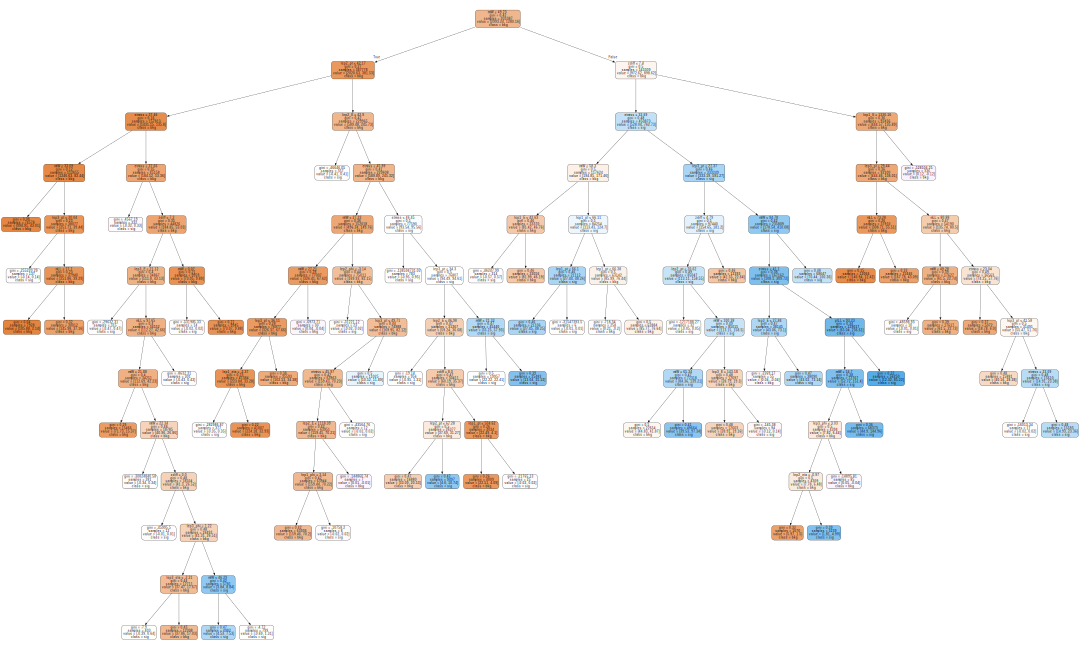

In [ ]:
draw_tree(clf, xs, size=15, leaves_parallel=False, precision=2, class_names=['bkg', 'sig'])

With a decision tree, we have managed to signal/bkg ratio of 11.16 while keeping almost 700 signals.

In [ ]:
clf.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.32184162e-03, 5.81576756e-03,
       1.14160104e-04, 7.86998755e-01, 1.46244250e-01, 3.07539298e-03,
       1.29379748e-02, 1.46621107e-02, 1.29747622e-04, 5.98274379e-03,
       1.00430614e-04, 6.82960684e-03, 2.49870478e-04, 6.89916684e-03,
       1.24147801e-04, 5.98260534e-03, 5.31428332e-04])

<AxesSubplot: >

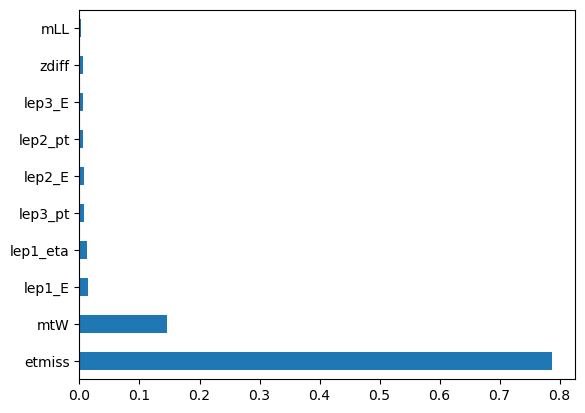

In [ ]:
# Associate the feature importances with the feature names
feat_importances = pd.Series(clf.feature_importances_, index=train_xs.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh')

In [ ]:
probs= clf.predict_proba(valid_xs)
probs.min(), probs.max()

(-8324.003935101024, 8325.003935101024)

Using sample weights with negative values is an issue, because it leads to probability predictions out of the [0, 1] range.